In [1]:
import os
from glob import glob

import pandas as pd
import geopandas as gpd
import matplotlib
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

/tmp/ipykernel_1394946/1295605207.py:5: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# model outputs
root_path = "/home/fred/projects/open_gira/open-gira/"
tracks_path = os.path.join(root_path, "results/input/IBTrACS/processed/v4.geoparquet")
targets_path = os.path.join(root_path, "results/power/targets_with_iso_a3.geoparquet")
exposure_path = os.path.join(root_path, "results/power/by_storm_set/IBTrACS/exposure_by_country.nc")

# validation data
# https://www.un.org/development/desa/pd/data/household-size-and-composition
household_path = os.path.join(root_path, "undesa_pd_2022_hh-size-composition.xlsx")
# https://gist.githubusercontent.com/tadast/8827699/raw/f5cac3d42d16b78348610fc4ec301e9234f82821/countries_codes_and_coordinates.csv
iso_codes = os.path.join(root_path, "iso_codes.csv")
# see source column
outage_paths = glob(os.path.join(root_path, "validation/*.csv"))

In [4]:
# read iso numeric to alpha table
rename_dict = {
    "Country": "name",
    "Alpha-2 code": "iso_a2",
    "Alpha-3 code": "iso_a3",
    "Numeric code": "iso_num"
}
iso = pd.read_csv(iso_codes, usecols=rename_dict.keys())
iso = iso.rename(columns=rename_dict)
# strip out quotes
for c in iso.columns:
    iso[c] = iso[c].str.replace('"', "").str.strip()
iso.iso_num = iso.iso_num.astype(int)

In [5]:
# read household size data
rename_dict = {
    "ISO Code": "iso_num",
    "Reference date (dd/mm/yyyy)": "ref_date",
    "Average household size (number of members)": "mean_household_pop"
}
hh = pd.read_excel(household_path, sheet_name="HH size and composition 2022", header=4, usecols=rename_dict.keys())
hh = hh.rename(columns=rename_dict)
hh.ref_date = pd.to_datetime(hh.ref_date, dayfirst=True)
# any non-numeric value -> NaN (some '..' placeholders in excel data)
hh["mean_household_pop"] = pd.to_numeric(hh["mean_household_pop"], errors="coerce")

# discard all but most recent entry for each territory
hh = hh.sort_values(["ref_date"], ascending=False).drop_duplicates("iso_num", keep="first")

# merge in iso alpha ids (will permit join with outage data)
hh = hh.merge(iso, how="left", on="iso_num")

In [6]:
# now compare population_affected with the exposure_by_country.nc data
ds = xr.open_dataset(exposure_path).rename({"country": "country_iso_a3"})

by_threshold = {}
for threshold in ds.threshold.values:

    # storm loop
    by_storm = {os.path.basename(p).split(".")[0]: pd.read_csv(p) for p in sorted(outage_paths)}
    for event_id, obs in by_storm.items():
        
        if event_id == "2018292N14261":
            # skip our storm horribilis
            continue
            
        obs = obs.rename(columns={"country_iso_a3": "iso_a3"}).merge(hh, how="left", on="iso_a3")

        for i in range(len(obs)):
            # gap-fill the population_affected numbers where we have customers_affected only
            if pd.isna(obs.loc[i, "population_affected"]):
                by_storm[event_id].loc[i, "population_affected"] = \
                    obs.loc[i, "customers_affected"] * obs.loc[i, "mean_household_pop"]

        # take the largest estimate for each country (we assume reports underestimate outages)
        by_storm[event_id] = by_storm[event_id].groupby("country_iso_a3").max()
        by_storm[event_id] = by_storm[event_id][["population_affected"]]
        by_storm[event_id] = by_storm[event_id].rename(columns={"population_affected": "observed"})

        try:
            # select model data for given storm and threshold
            mod = ds.customers_affected.sel(dict(event_id=event_id, threshold=threshold)).to_pandas()
        except KeyError:
            # storm has no modelled results
            continue

        # non-zero modelled customers_affected (really population affected, should change this name!)
        mod = mod[mod > 0]
        mod.name = "modelled"
        by_storm[event_id] = by_storm[event_id].join(mod)
        by_storm[event_id]["error"] = \
            by_storm[event_id].modelled - by_storm[event_id].observed
        by_storm[event_id]["ratio"] = \
            by_storm[event_id].modelled / by_storm[event_id].observed
        by_storm[event_id]["error_norm"] = \
            by_storm[event_id].error / by_storm[event_id].observed

    concat = pd.concat(by_storm)
    concat.index.names = ["event_id", "country_iso_a3"]
    by_threshold[threshold] = concat

In [7]:
def categorical_cmap(cmap_name: str, categories: list) -> dict[str: tuple[float]]:
    scalar_mappable = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(0, 1), cmap_name)
    return {code: scalar_mappable.to_rgba(i / len(categories)) for i, code in enumerate(categories)}

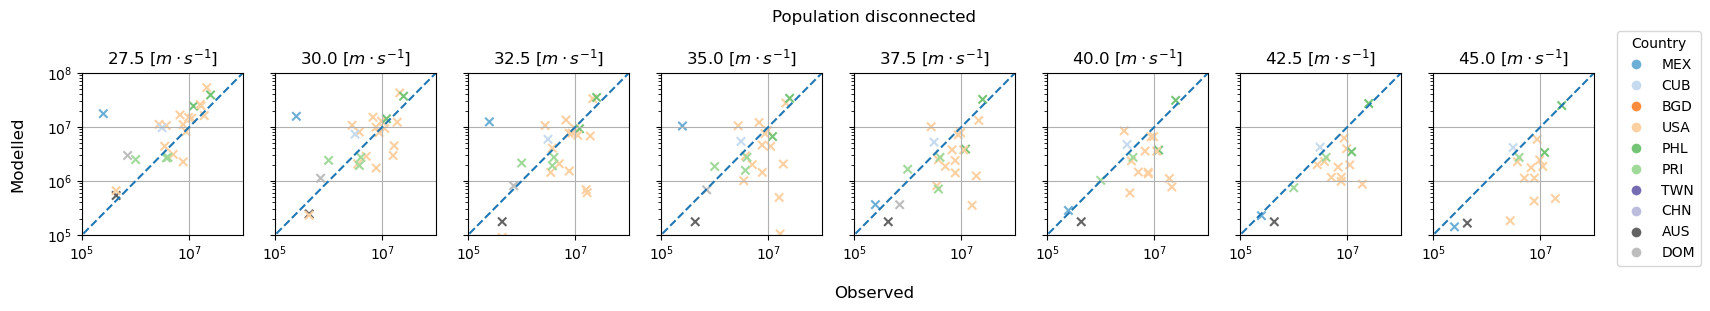

In [8]:
# scatter plot modelled vs. observed by threshold

# make a country colormap
# collect all country codes
iso_codes = set(by_threshold[min(ds.threshold.values)].index.get_level_values("country_iso_a3").values)
# generate RGBA values for each code
cmap = categorical_cmap("tab20c", iso_codes)

n = len(by_threshold.keys())
f, axes = plt.subplots(ncols=n, figsize=(18,3), sharey=True)
for threshold, ax in zip(by_threshold.keys(), axes):
    data = by_threshold[threshold]
    
    # build a list of RGBA values the same length as the data
    colours = [cmap[value] for value in data.index.get_level_values("country_iso_a3").values]

    ax.scatter(data.observed, data.modelled, marker="x", c=colours)
    x = np.linspace(0, 10 * max(data.observed), 100)
    ax.plot(x, x, ls="--")
    ax.grid()
    ax.set_title(f"{threshold} $[m \cdot s^{{-1}}]$")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(1E5, 1E8)
    ax.set_ylim(1E5, 1E8)
    
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in cmap.items() if isinstance(k, str)]
ax.legend(title='Country', handles=handles, bbox_to_anchor=(1.1, 1.3))
    
f.supxlabel("Observed")
f.supylabel("Modelled")
f.suptitle("Population disconnected")

plt.subplots_adjust(bottom=0.23, top=0.77, left=0.06, right=0.9)

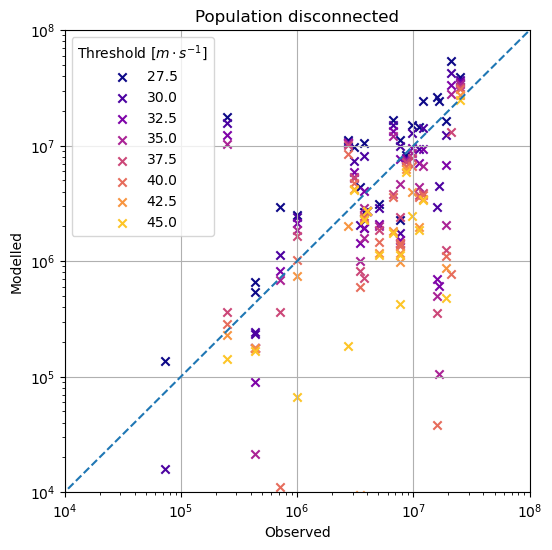

In [9]:
# scatter plot modelled vs. observed by threshold (same plot)

f, ax = plt.subplots(figsize=(6, 6))

cmap = categorical_cmap("plasma", by_threshold.keys())
    
for threshold in by_threshold.keys():
    data = by_threshold[threshold]
    ax.scatter(data.observed, data.modelled, marker="x", label=threshold, color=cmap[threshold])
    
x = np.linspace(0, 10 * max(data.observed), 100)
ax.plot(x, x, ls="--")
ax.grid()
ax.set_title("Population disconnected")
ax.set_xlabel("Observed")
ax.set_ylabel("Modelled")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1E4, 1E8)
ax.set_ylim(1E4, 1E8)
ax.legend(title="Threshold $[m \cdot s^{{-1}}]$")

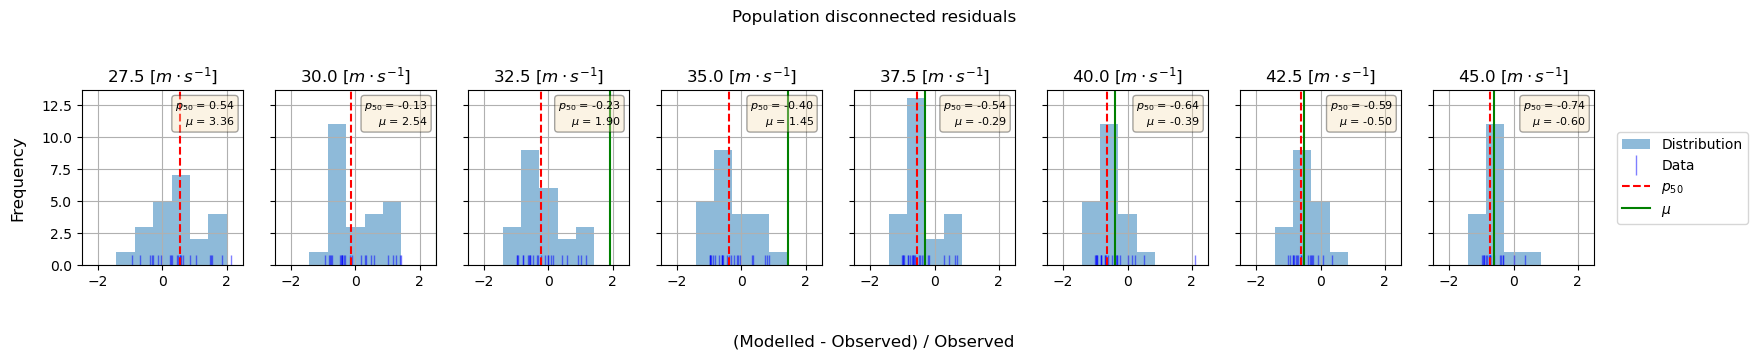

In [14]:
# plot residual distributions by threshold
n = len(by_threshold.keys())
f, axes = plt.subplots(ncols=n, figsize=(18,3.5), sharey=True)
for threshold, ax in zip(by_threshold.keys(), axes):
    e = by_threshold[threshold].error_norm
    
    ax.grid()
    
    # distribution
    ax.hist(
        e,
        bins=np.linspace(-2, 2, 8),
        alpha=0.5,
        label="Distribution"
    )
    
    # rug plot
    ax.plot(e, np.zeros(len(e)), 'b|', ms=15, alpha=0.5, label="Data")
    
    # average measures
    mean = np.nanmean(e)
    median = np.nanmedian(e)
    ax.axvline(median, ls="--", c="red", label=r"$p_{50}$")
    ax.axvline(mean, ls="-", c="green", label=r"$\mu$")


    x_half_width = 2.5
    ax.set_xlim(-x_half_width, x_half_width)
    ax.set_title(f"{threshold} $[m \cdot s^{{-1}}]$")

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.35)
    ax.text(
        0.95,
        0.95,
        "\n".join([f"$p_{{50}}$ = {median:.2f}", f"$\mu$ = {mean:.2f}"]),
        transform=ax.transAxes,
        fontsize=8,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=props
    )
    
ax.legend(bbox_to_anchor=(2, 0.8))

f.supxlabel("(Modelled - Observed) / Observed")
f.supylabel("Frequency")
f.suptitle("Population disconnected residuals")

plt.subplots_adjust(bottom=0.25, top=0.75, left=0.06, right=0.9)

Text(0, 0.5, 'Frequency')

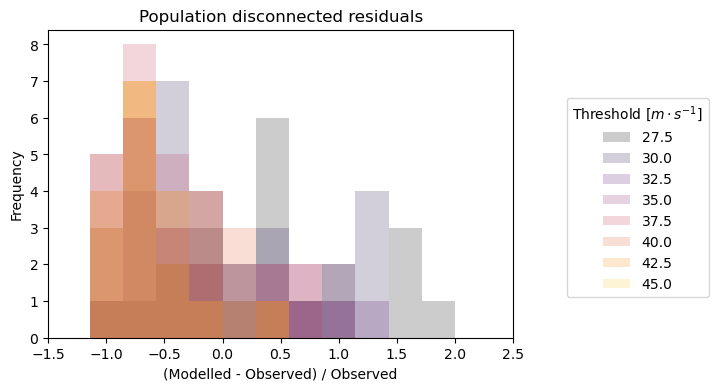

In [11]:
# over plot residual distributions by threshold
f, ax = plt.subplots(figsize=(6, 4))

scalar_mappable = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(0, 1), "inferno")
cmap = {code: scalar_mappable.to_rgba(i / len(by_threshold.keys())) for i, code in enumerate(by_threshold.keys())}

for threshold in by_threshold.keys():
    
    e = by_threshold[threshold].error_norm
    ax.hist(
        e,
        bins=np.linspace(-2, 2, 15),
        alpha=0.2,
        label=threshold,
        color=cmap[threshold]
    )
    
ax.set_xlim(-1.5, 2.5)
ax.legend(title="Threshold $[m \cdot s^{-1}]$", bbox_to_anchor=(1.1, 0.8))
ax.set_title("Population disconnected residuals")
ax.set_xlabel("(Modelled - Observed) / Observed")
ax.set_ylabel("Frequency")